In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%%capture
!pip install spectrum
import numpy as np
import scipy
import scipy.io
from scipy import signal
import matplotlib.pyplot as plt
from scipy.fftpack import fft

In [3]:
# Leitura dos dados
mat = np.genfromtxt("/content/drive/MyDrive/ProcSin/dataset/EMG-S10/R-R6.csv", delimiter=',')

# Domínio do tempo

In [4]:
def fourier(x, t, Hz=False, dB=False, deg=False, Nfft=None):
    N = len(x)

    if Nfft is None:
      Nfft = N

    T = np.mean(t[1:] - t[:-1])
    X_f = fft(x, n=Nfft)
    X_f = X_f/N
    X_f = X_f[:Nfft//2]
    X_f[1:] = 2*X_f[1:]

    f0 = 1/(Nfft*T)
    fHz = np.arange(Nfft)*f0
    fHz = fHz[:Nfft//2]

    w0 = 2*np.pi/(Nfft*T)
    wRad = np.arange(Nfft)*w0
    wRad = wRad[:Nfft//2]
    
    if dB:
      X_f_db = 20*np.log10(np.abs(X_f))

    return np.abs(X_f) if not dB else X_f_db, np.angle(X_f, deg), fHz if Hz else wRad

def plot_channels(ch1, ch2, t, desc=" ", lim=(0, 450), freq_domain = False, hold_on = False):
  if freq_domain:
    magCh1, _, freq = fourier(ch1, t, Hz=True)
    magCh2, _, _ = fourier(ch2, t, Hz=True)

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 5))

  # Channel 1
  ax1.plot(freq if freq_domain else t, magCh1 if freq_domain else ch1, "k")
  ax1.set_xlim(lim if freq_domain else None)
  ax1.set_ylabel("$|CH1(j\omega)|$" if freq_domain else "CH1, V")
  ax1.set_title(f"Canais{desc}no domínio {'da frequência' if freq_domain else 'do tempo'}")
  ax1.grid()

  # Channel 2
  ax2.plot(freq if freq_domain else t, magCh2 if freq_domain else ch2, "b")
  ax2.set_xlim(lim if freq_domain else None)
  ax2.set_xlabel("Frequência [Hz]" if freq_domain else "Tempo [s]")
  ax2.set_ylabel("$|CH2(j\omega)|$" if freq_domain else "CH2, V")
  ax2.grid()

  fig.tight_layout()

  if hold_on:
    return ax1, ax2
  else:
    plt.show()

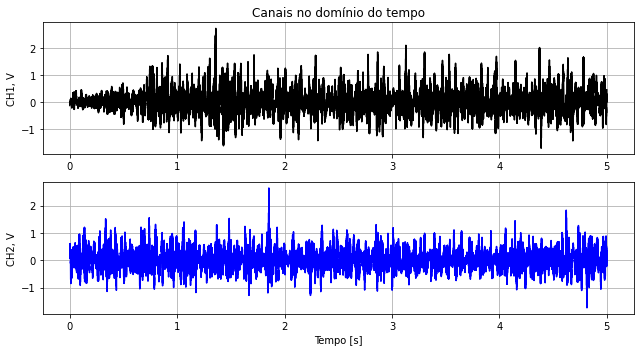

In [5]:
fs = 4000
samples = len(mat)
t = np.arange(samples/fs, step=1/fs)

chs = mat.reshape((2, samples))
ch1 = chs[0] * 1000
ch2 = chs[1] * 1000

plot_channels(ch1, ch2, t)

# Domínio da frequência

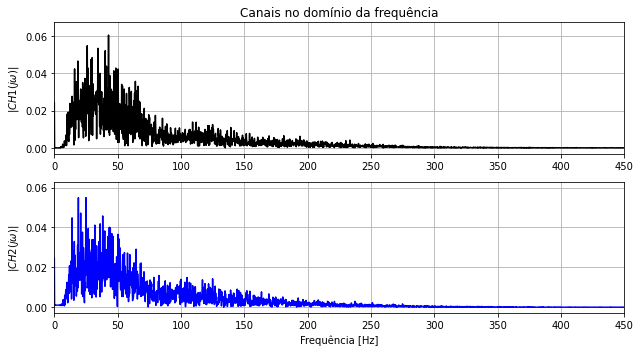

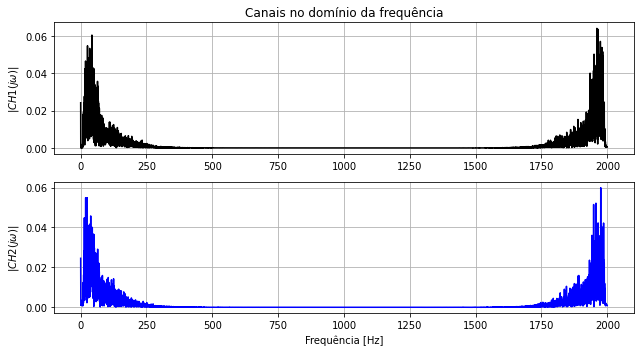

In [6]:
plot_channels(ch1, ch2, t, freq_domain = True)

plot_channels(ch1, ch2, t, freq_domain = True, lim=None)

# Filtragem

Será aplicado um filtro passa banda de 20 - 450 Hz (por quê?)

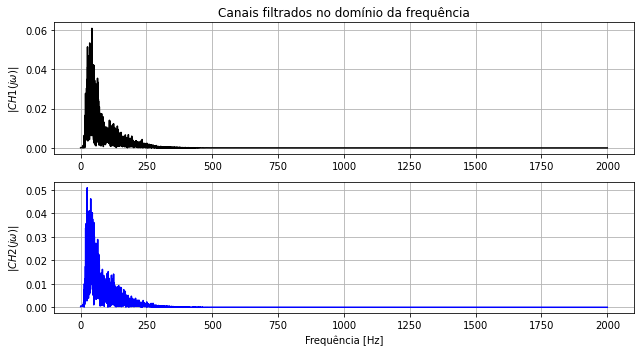

In [7]:
wp1 = 20 # Freq de passagem 1
wp2 = 450 # Freq de passagem 2

# Filtro passa-faixa usando output "sos" (Second Order Sections)
sos = signal.butter(4, [wp1, wp2], "bandpass", fs=fs, output="sos") 

# Filtrar os canais
y_ch1 = signal.sosfilt(sos, ch1)
y_ch2 = signal.sosfilt(sos, ch2)

plot_channels(y_ch1, y_ch2, t, freq_domain = True, desc = " filtrados ", lim=None)

Os dados usados foram coletados na **Australia** que utiliza frequência de 50 Hz nas linhas de transmissão, para remover a interferência que os equipamentos podem causar será aplicado um filtro Notch (filtro rejeita faixa com faixa reduzida) a fim de eliminar a frequência específica.

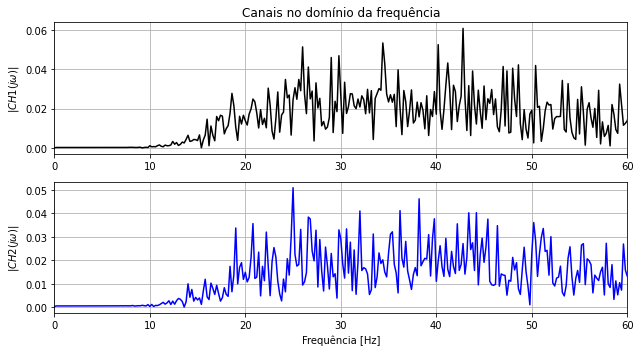

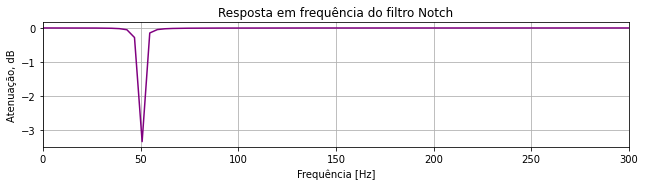

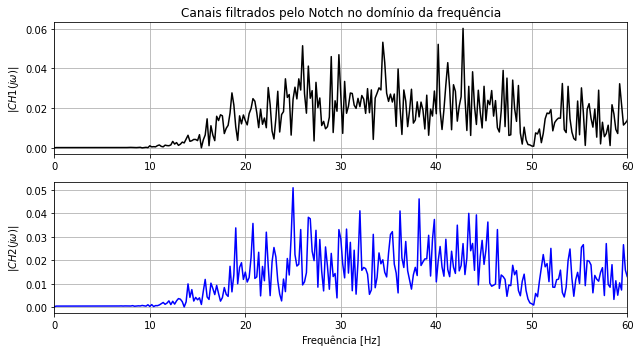

In [8]:
# Criar filtro Notch
notch_freq = 50.0 
quality_factor = 30.0 
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)
freq, h = signal.freqz(b_notch, a_notch, fs = fs)

plot_channels(y_ch1, y_ch2, t, freq_domain = True, lim = (0, 60))

plt.figure(figsize=(10.5, 2.3))
plt.plot(freq, 20*np.log10(abs(h)), "purple")
plt.grid()
plt.xlim(0, 300)
plt.xlabel("Frequência [Hz]")
plt.ylabel("Atenuação, dB")
plt.title("Resposta em frequência do filtro Notch")
plt.show()

# Aplicar filtro aos canais
y_n_ch1 = signal.filtfilt(b_notch, a_notch, y_ch1)
y_n_ch2 = signal.filtfilt(b_notch, a_notch, y_ch2)

plot_channels(y_n_ch1, y_n_ch2, t, freq_domain = True, lim = (0, 60), desc = " filtrados pelo Notch ")

# Extração de features
Feature extraction is the transformation of the raw signal data into a relevant data structure by removing noise, and highlighting the important data. There are three main categories of features important for the operation of an EMG based control system. Those being the time domain, frequency domain, and the time-frequency domain [1,5]. However, due to the intense computation needs of transformations required by the features in the time-frequency domain, this method is not used for therapeutic devices.

 The **Fourier transform** is not appropriate for analysing non-stationary signals in which textures are irregular or non-uniform. Short time Fourier transform or Wavelet might be the most appropriate techniques to analyse non-stationary signals. However, these methods deal with a large number of data points, thereby causing difficulties at the classification step. More features require more training samples resulting in the growth of the computational complexity as well as the risk of over-fitting.

# Slope Sign Changes (SSC)

A feature which may provide 
another measure of frequency content is the number of times 
the slope of the waveform changes sign. Once again a suitable 
threshold must be chosen to reduce noise induced slope sign 
changes. 

In [9]:
def slope_sign_changes(x):
  ssc = 0
  for k in range(1, len(x)-1):
    if (x[k] > x[k-1] and x[k] >  x[k+1]) or (x[k] < x[k-1] and x[k] < x[k+1]) \
      and (np.abs(x[k] - x[k+1]) >= 0.01 or np.abs(x[k] - x[k-1]) >= 0.01):
      ssc +=1
  return ssc

print(slope_sign_changes(y_n_ch1), slope_sign_changes(y_n_ch2))

639 616


# Number of Zero Crossings (ZC)
A simple frequency measure can be obtained by counting the number of times the waveform crosses zero.



In [10]:
def zero_crossings(x):
  zc = 0
  for k in range(len(x)-1):
    if (x[k] > 0 and x[k+1] < 0) or (x[k] < 0 and x[k+1] > 0) \
     and np.abs(x[k] - x[k+1]) >= 0.01:
      zc += 1
  return zc

print(zero_crossings(y_n_ch1), zero_crossings(y_n_ch2))

540 575


# Hjorth Time Domain Parameters (HTD)
Hjorth parameters are indicators of statistical properties used in signal processing in the time domain introduced by Bo Hjorth in 1970.[1] The parameters are Activity, Mobility, and Complexity.

- The **Activity** parameter is the total power of the signal. It is also the surface of the power spectrum in the frequency domain (Parseval's theorem).

- The **Mobility** is proportional to a standard deviation of the power spectrum. It is an estimate of the mean frequency. 

- **Complexity** gives an estimate of the bandwidth of the signal, which indicates the similarity of the shape of the signal to a pure sine wave. 

Since the calculation of the Hjorth parameters is based on variance, the computational cost of this method is sufficiently low, which makes them appropriate for the real-time task.



In [11]:
def htd_parameters(x):

  def calc_mobility(x):
    return np.sqrt(np.var(np.diff(x)) / np.var(x))

  mobility = calc_mobility(x)
  complexity = calc_mobility(np.diff(x)) / mobility

  return mobility, complexity

print(htd_parameters(y_n_ch1), htd_parameters(y_n_ch2))

(0.09380695156744862, 2.015217322466897) (0.09880962529314234, 1.9382289810648743)


# Sample Skewness (SS)
kewness measures asymmetry/distortion of a distribution. When amplitudes of samples of EMG segment are represented as a distribution, skewness can be measured.


In [12]:
def skewness(x):
  N = len(x)
  std = np.std(x)
  mean = np.mean(x)

  skewness = 0.0
  for i in range(0, N):
    skewness += np.power((x[i] - mean), 3)
    
  skewness /= ((N - 1) * np.power(std, 3))

  return skewness

print(skewness(y_n_ch1), skewness(y_n_ch2))

-0.087129169287395 -0.0698918003328444


# IEMG
IEMG is the area under the curve of the rectified EMG segment. It can be expressed as the summation of all absolute values of amplitude (Spiewak, et al., 2018).

In [13]:
def integrated_emg(x):
  return np.sum(np.abs(x))

integrated_emg(y_n_ch1), integrated_emg(y_n_ch2)

(4114.648113523777, 3680.4566975836515)

# Log Detector
Provides an estimate of the exerted muscle force. This is a non-linear feature (Tkach & Huang, 2010).

In [14]:
def log_detector(x):
  return np.power(np.e, np.sum(np.log10(np.abs(x)))/len(x))

log_detector(y_n_ch1), log_detector(y_n_ch2)

(0.41547696357387354, 0.3985758157363161)

# Maximum Fractal Length (MFL)
MFL measures the strength of muscle contraction even though it is very similar to Wavelength. MFL includes a logarithmic scale, which makes it less vulnerable to noise (Arjunan & Kumar, 2010).

In [15]:
def maximum_fractal_length(x):
  return np.log10(np.sqrt(np.sum(np.power(x[1:] - x[:-1], 2))))

maximum_fractal_length(y_n_ch1), maximum_fractal_length(y_n_ch2)

(0.5440405055673583, 0.5152662412153762)

# Mean Absolute Value (MAV)


In [16]:
def mean_absolute_value(x):
  return np.mean(np.abs(x))

mean_absolute_value(y_n_ch1), mean_absolute_value(y_n_ch2)

(0.20573240567618886, 0.18402283487918258)

# Waveform Length (WL)

A feature which provides information on the waveform complexity in each segment is the waveform length. The resultant values gives a measure of waveform amplitude, frequency, and duration all within a single parameter.

In [17]:
def waveform_length(x):
  return np.sum(np.abs(x[1:] - x[:-1]))

waveform_length(y_n_ch1), waveform_length(y_n_ch2)

(380.83171297941607, 359.17231230085025)

# AutoRegressive (AR)

Autoregressive model describes each sample of the segment as a linear combination of previous samples and an error term.

In [18]:
from spectrum import arburg
def auto_regressive(x, order=10):
  y  = arburg(x, order) 
  AR = y[2 : order + 1]
  return tuple(np.real(AR)[0])

auto_regressive(y_n_ch1), auto_regressive(y_n_ch2)

((-0.9955998348690366,
  0.9864960397693253,
  -0.9672499829465872,
  0.9672199689366505,
  -0.9227483724242569,
  0.8672768826908906,
  -0.3598906824172393,
  -0.42238843161968864,
  0.26757278142458235,
  0.31407249353508276),
 (-0.9951182859699153,
  0.9865038627104115,
  -0.9676193343528461,
  0.9476741186293894,
  -0.885853871662301,
  0.8410561097619913,
  -0.4977602579451879,
  -0.0912792252297562,
  0.263138651744113,
  0.05027461259857004))

# Average Amplitude Change


In [19]:
def average_amplitude_change(x):
  return np.sum(np.abs(x[1:] - x[:-1]))/len(x)

average_amplitude_change(y_n_ch1), average_amplitude_change(y_n_ch2)

(0.019041585648970804, 0.017958615615042514)

# Log Difference Absolute Mean Value (LDAMV)


In [20]:
def log_diff_abs_mean_value(x):
  return np.log10(np.sum(np.abs(x[1:] - x[:-1]))/len(x))

log_diff_abs_mean_value(y_n_ch1), log_diff_abs_mean_value(y_n_ch2)

(-1.7202968894638881, -1.745727145058523)

# Log Teager Kaiser Energy Operator (LTKEO)
Teager Kaiser Energy operator measures instantaneous changes in energy of the signals composed of a single time-varying frequency (Khushaba, et al., 2017).

In [21]:
def ltkeo(x):
  sum = 0.0
  for j in range(1, len(x)-1):
    sum += np.power(x[j], 2) - x[j-1]*x[j+1]

  return np.log10(sum)

ltkeo(y_n_ch1), ltkeo(y_n_ch2)

(1.3850270936256774, 1.3274058153826953)

# Difference Mean Absolute Value (DMAV)

In [22]:
def diff_mean_avg_value(x):
  return np.sum(np.abs(x[1:] - x[:-1]))/(len(x)-1)

diff_mean_avg_value(y_n_ch1), diff_mean_avg_value(y_n_ch2)

(0.019042537775859597, 0.017959513590722048)

# Modified Mean Absolute Value (MMAV)
MMAV is an expansion of MAV with a continuous weighted window function (wi) (Phinyomark, et al., 2012)

In [23]:
def mod_mean_abs_value(x):
  N = len(x)
  sum = 0.0
  for i in range(len(x)):
    if i >= 0.25*N and i <= 0.75*N:
      wi = 1
    elif i < 0.25*N:
      wi = 4*i/N
    else:
      4*(i - N)/N
    
    sum += wi*np.abs(x[i])

  return sum / N

mod_mean_abs_value(y_n_ch1), mod_mean_abs_value(y_n_ch2)

(0.19079468185219156, 0.16091168342479858)

# Temporal Moment (TM)
The temporal moment is a statistical analysis technique that can be used as a feature. Since the first and second order of TM is MAV and Variance, 3rd order and above is taken (Phinyomark, et al., 2012).

In [24]:
def temporal_moment(x, order=3):
  return np.abs(np.sum(np.power(x, order)) / len(x))

temporal_moment(y_n_ch1), temporal_moment(y_n_ch2)

(0.0016207478850063706, 0.0008569654144237841)

# Myopulse Percentage Rate (MYOP)
MYOP is defined as the mean absolute value of the EMG segment but with a threshold value for the amplitude of each sample (Phinyomark, et al., 2012).

In [25]:
def myop(x):
  x = np.abs(x)
  return np.sum([xi for xi in x if xi > 0.016]) / len(x)

myop(y_n_ch1), myop(y_n_ch2)

(0.20529390330393943, 0.1835547933873312)

# Mean Absolute Deviation (MAD)
The mean absolute deviation measures the average distance between each sample of the EMG segment and the mean (Verma & Gupta , 2020).

In [26]:
def mean_absolute_deviation(x):
  mean = np.mean(x)
  return np.sum(np.abs(x - mean)) / len(x)

mean_absolute_deviation(y_n_ch1), mean_absolute_deviation(y_n_ch2)

(0.205734644597786, 0.18402134889202584)

# v-Order (VO)
v-Order implicitly estimates the force of muscle contraction. It is a non-linear function (Phinyomark, et al., 2012).

In [27]:
def v_order(x, order=2):
  sum = np.sum(np.power(x, order))/len(x)
  return np.sign(sum) * np.power(np.abs(sum), (1/order))

v_order(y_n_ch1), v_order(y_n_ch2)

(0.2638159829274797, 0.23440289714916962)

# Willison Amplitude (WA)
Willison amplitude measures the frequency information in the EMG segment. It calculates the number of times a difference between two adjacent amplitudes exceeds a certain threshold. It is found to be related to muscle contraction force and firing of motor unit action potentials (Phinyomark, et al., 2012).

In [28]:
def willison_amplitude(x):
  return np.sum([1 for xf in np.abs(x[:-1] - x[1:]) if xf >= 0.01])

willison_amplitude(y_n_ch1), willison_amplitude(y_n_ch2)

(12844, 12854)

# Extração de features

In [29]:
def extract_features(filepath):
  mat = np.genfromtxt(filepath, delimiter=',')
  samples = len(mat)
  mat = mat.reshape((2, samples))

  # Downsampling (para 1000 Hz)
  ch1 = signal.decimate(mat[0], 4) * 1000
  ch2 = signal.decimate(mat[1], 4) * 1000

  # Filtro passa-faixa
  y_ch1 = signal.sosfilt(sos, ch1)
  y_ch2 = signal.sosfilt(sos, ch2)

  # Filtro notch
  y_n_ch1 = signal.filtfilt(b_notch, a_notch, y_ch1)
  y_n_ch2 = signal.filtfilt(b_notch, a_notch, y_ch2)

  features = (
      # 1. AutoRegressive Coefficients
      *auto_regressive(y_n_ch1), 
      *auto_regressive(y_n_ch2),
      # 2. Average Amplitude Change
      average_amplitude_change(y_n_ch1), 
      average_amplitude_change(y_n_ch2),
      # 3. Difference Mean Absolute Value
      diff_mean_avg_value(y_n_ch1),
      diff_mean_avg_value(y_n_ch2),
      # 4. Log Detector
      log_detector(y_n_ch1), 
      log_detector(y_n_ch2),
      # 5. Integrated EMG
      integrated_emg(y_n_ch1),
      integrated_emg(y_n_ch2),
      # 6. Log Differrence Absolute Value
      log_diff_abs_mean_value(y_n_ch1), 
      log_diff_abs_mean_value(y_n_ch2),
      # 7. Log Teager Kaiser Energy Operator
      ltkeo(y_n_ch1), 
      ltkeo(y_n_ch2),
      # 8. Slope Sign Changes
      slope_sign_changes(y_n_ch1), 
      slope_sign_changes(y_n_ch2),
      # 9. Zero Crossings
      zero_crossings(y_n_ch1), 
      zero_crossings(y_n_ch2),
      # 10. HTD Parameters
      *htd_parameters(y_n_ch1), 
      *htd_parameters(y_n_ch2),
      # 11 Skewness
      skewness(y_n_ch1),
      skewness(y_n_ch2),
      # 12. Maximum Fractal Length
      maximum_fractal_length(y_n_ch1), 
      maximum_fractal_length(y_n_ch2),
      # 13. Mean Absolute Value
      mean_absolute_value(y_n_ch1), 
      mean_absolute_value(y_n_ch2),
      # 14. Waveform length
      waveform_length(y_n_ch1), 
      waveform_length(y_n_ch2),
      # 15. Modified Mean Absolute Value
      mod_mean_abs_value(y_n_ch1), 
      mod_mean_abs_value(y_n_ch2),
      # 16. Temporal Moment
      temporal_moment(y_n_ch1), 
      temporal_moment(y_n_ch2),
      # 17. Myopulse Percentage Rate
      myop(y_n_ch1), 
      myop(y_n_ch2),
      # 18. Mean Absolute Deviation
      mean_absolute_deviation(y_n_ch1), 
      mean_absolute_deviation(y_n_ch2),
      # 19. v-Order
      v_order(y_n_ch1), 
      v_order(y_n_ch2),
      # 20. Willison Amplitude
      willison_amplitude(y_n_ch1), 
      willison_amplitude(y_n_ch2)
  )

  return features
        

In [30]:
# %%script echo skipping
import os
from IPython.display import HTML

def progress(value):
    return HTML("""
        <progress
            value='{value}'
            max='60',
            style='width: 30%'
        >
            {value}
        </progress>
    """.format(value=value))



features = []
labels = []

fcount = 0
for subfolder in sorted(os.listdir('/content/drive/MyDrive/ProcSin/dataset/')):
  fcount += 1
  display(HTML(f"<b>[{fcount}/10] Processando {subfolder}...</b>"))
  bar = display(progress(0), display_id=True)

  count = 0
  for file in os.listdir(f'/content/drive/MyDrive/ProcSin/dataset/{subfolder}'):
    features.append(extract_features(f'/content/drive/MyDrive/ProcSin/dataset/{subfolder}/{file}'))
    labels.append(file.replace("-", "")[:-5])
    count += 1
    bar.update(progress(count))
  
  bar.update(HTML(""))

display(HTML("<b style='color: red;'>Processamento finalizado!</b>"))

# Classificação - KNN

Acurácia: 81.67%


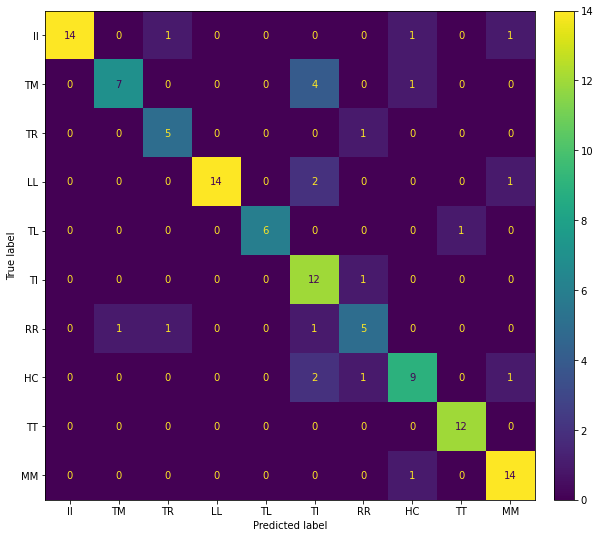

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

X = features
y = labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345
)

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

print(f"Acurácia: {(accuracy_score(y_test, y_pred)*100):.2f}%")

fig, ax = plt.subplots(figsize=(9, 9))
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=set(y_test))
cmp.plot(ax=ax, colorbar=False)
cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)
plt.show()

# Visualização

In [32]:
import ipywidgets as widgets
from google.colab import output
from IPython.display import display

index_map = {}
for i, label in enumerate(y_test):
  if label not in index_map:
    index_map[label] = []
  index_map[label].append(i)


label_map = {
    "HC": "Mão fechada",
    "TT": "Polegar",
    "II": "Indicador",
    "MM": "Médio",
    "RR": "Anelar",
    "LL": "Mínimo",
    "TI": "Polegar-Indicador",
    "TM": "Polegar-Médio",
    "TR": "Polegar-Anelar",
    "TL": "Polegar-Mínimo"
}

mw = widgets.Dropdown(
    options=[
         (label_map[t], t) for t in set(y_test)
        ],
    description='<b>Movimento:</b>',
    disabled=False,
)

iw = widgets.Dropdown(
    options=["Selecione o movimento"],
    description='<b>Iteração:</b>',
    disabled=True,
)

def on_change(change):

    if change['type'] == 'change' and change['name'] == 'value':
        
        iw.options = [
          (f"Teste {i + 1}", index_map[mw.value][i]) for i in range(len(index_map[mw.value]))
        ]
        iw.disabled = False

        output.clear()
        display(mw)
        display(iw)

        expected = mw.value
        predicted = knn_model.predict([X_test[iw.value]])[0]

        img_pre = widgets.Image(value=open(f'/content/drive/MyDrive/ProcSin/imgs/{predicted}.png', 'rb').read())
        display(img_pre)

mw.observe(on_change)
iw.observe(on_change)

display(mw)
display(iw)

Dropdown(description='<b>Movimento:</b>', options=(('Indicador', 'II'), ('Polegar-Médio', 'TM'), ('Polegar-Ane…

Dropdown(description='<b>Iteração:</b>', disabled=True, options=('Selecione o movimento',), value='Selecione o…

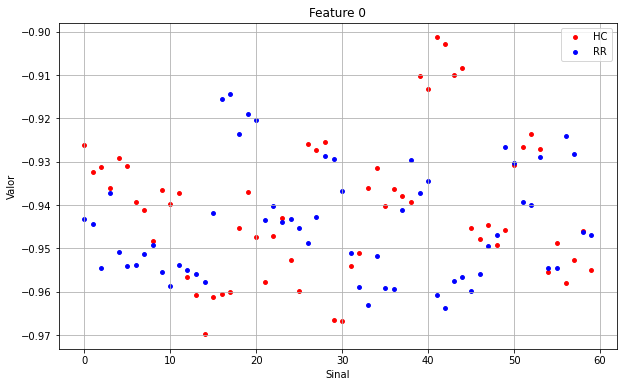

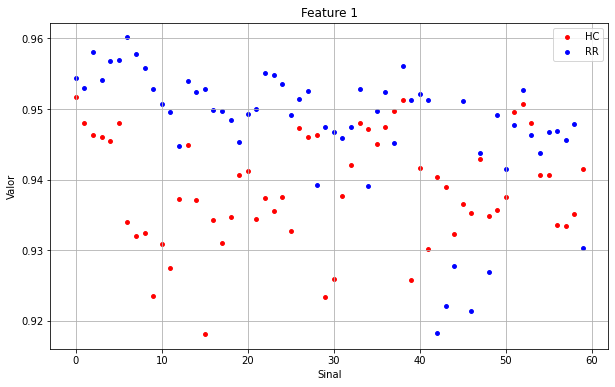

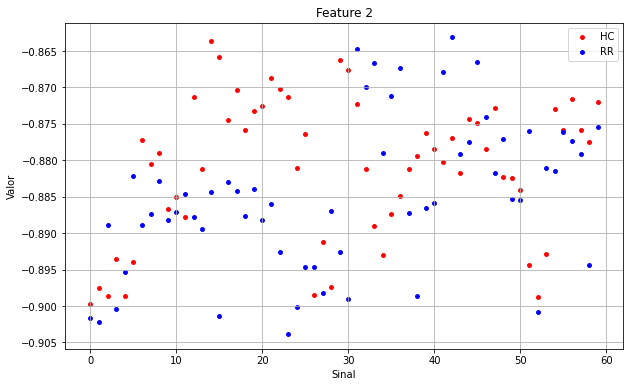

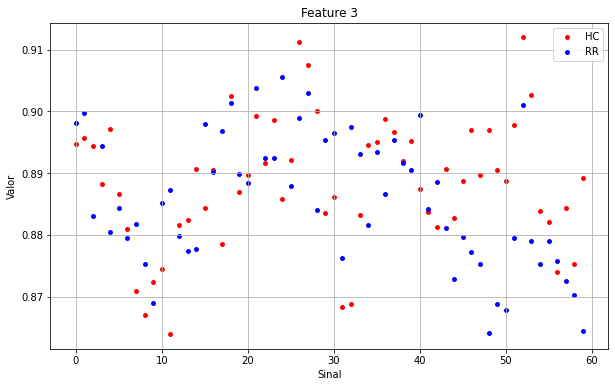

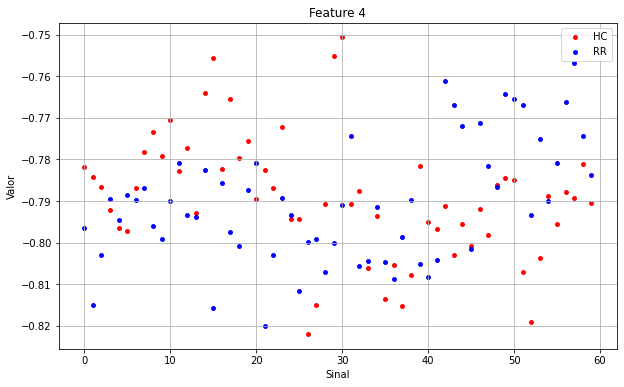

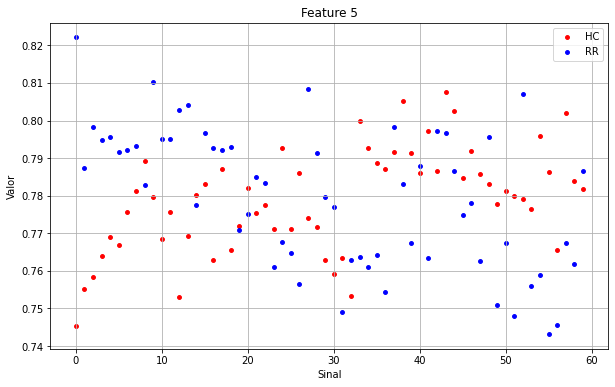

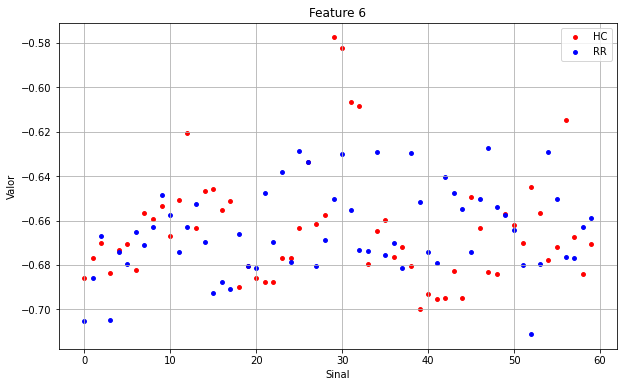

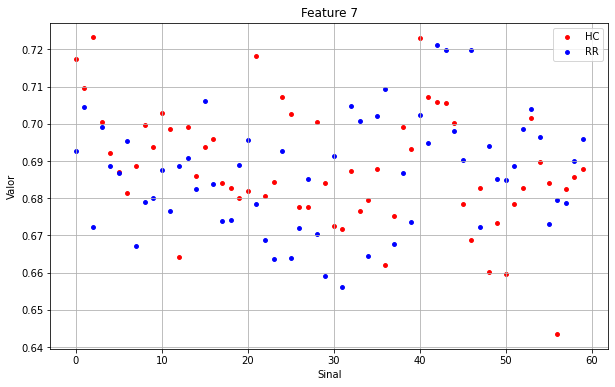

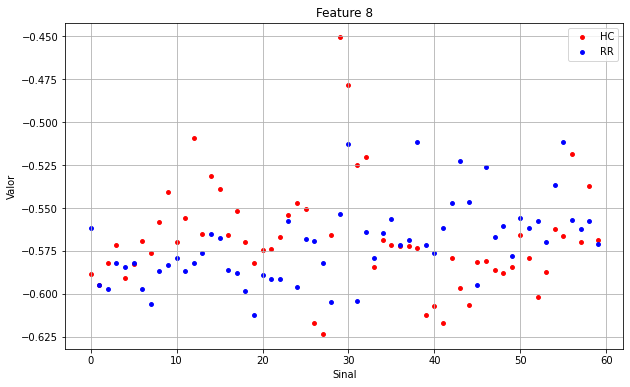

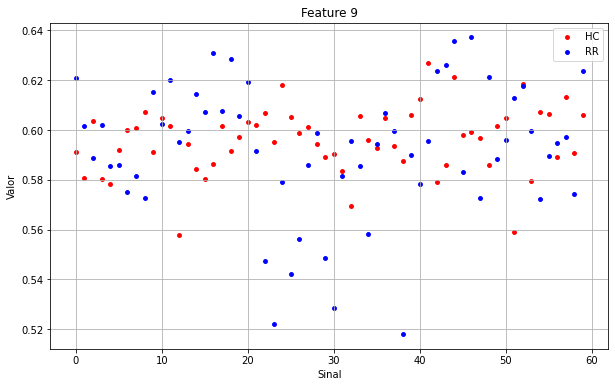

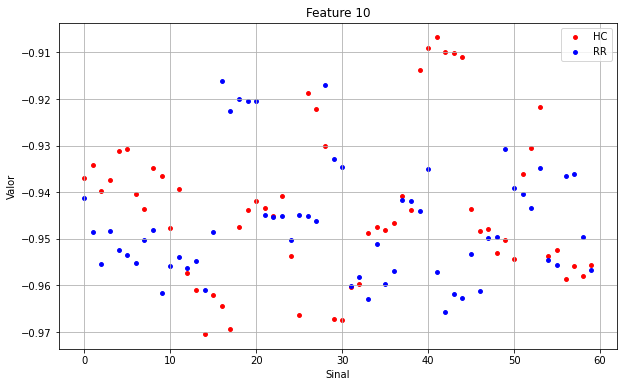

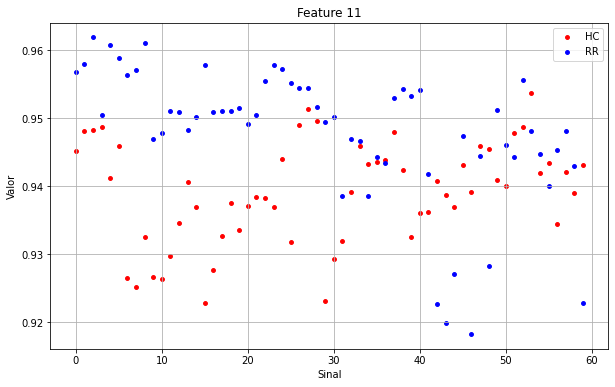

In [89]:
def r_feat(r, labels2, start, end):
  return [features[i][r] for i in labels2[start:end]]


labels2 = np.argsort(labels)
lab1, lab2 = labels[labels2[0]], labels[labels2[240]]
x = np.arange(60)

for r in range(12):
  feat1, feat2 = r_feat(r, labels2, 0, 60), r_feat(r, labels2, 240, 300)
  plt.figure(figsize=(10, 6))
  plt.scatter(x, feat1, s=15, c="r", label=lab1)
  plt.scatter(x, feat2, s=15, c="b", label=lab2)
  plt.title(f"Feature {r}")
  plt.xlabel("Sinal")
  plt.ylabel("Valor")
  plt.legend()
  plt.grid()
  plt.show()


# Referências
R. N. Khushaba, M. Takruri, S. Kodagoda, and G. Dissanayake, "Toward Improved Control of Prosthetic Fingers Using Surface Electromyogram (EMG) Signals", Expert Systems with Applications, vol 39, no. 12, pp. 10731–10738, 2012.

JAYAWEERA, Pasan Yashoda. Design and Implementation of Electromyography (EMG) based Real-Time Pattern Recognition model for Prosthetic hand Control. [S. l.: s. n.], 2020.